# Load Packages and State Paths


In [1]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.models as models
from torchvision import transforms
import nibabel as nib
import random
from torch.utils.data import DataLoader
import time



final_project_path = '/home/jws2215/e6691-2024spring-project-jwss-jws2215' # vm
data_folder_path = os.path.join(final_project_path, 'BraTS2020')
train_folder_path = os.path.join(data_folder_path, 'train')
valid_folder_path = os.path.join(data_folder_path, 'valid')


if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name: ", torch.cuda.get_device_name(0))
    allocated_memory = torch.cuda.memory_allocated() / (1024 ** 3)  # Convert bytes to gigabytes
    cached_memory = torch.cuda.memory_reserved() / (1024 ** 3)  # Convert bytes to gigabytes
    print(f"Allocated Memory: {allocated_memory:.2f} GB")
    print(f"Cached Memory: {cached_memory:.2f} GB")
    total_memory = torch.cuda.get_device_properties(device).total_memory / (1024 ** 3)  # Convert bytes to gigabytes
    print(f"Total GPU Memory: {total_memory:.2f} GB")
else:
    print("CUDA is not available. Cannot print memory usage.")
    device = torch.device('cpu')



GPU name:  Tesla T4
Allocated Memory: 0.00 GB
Cached Memory: 0.00 GB
Total GPU Memory: 14.58 GB


# Create the Dataset

In [2]:
def create_data_dictionary(folder_path):
    data_dict = {}
    subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    
    for idx, subfolder in enumerate(subfolders):
        abs_path = os.path.join(folder_path, subfolder)
        data_dict[idx] = {'absolute_path': abs_path, 'folder_name': subfolder}
    
    return data_dict

data_path_dictionary_train = create_data_dictionary(train_folder_path)
data_path_dictionary_valid = create_data_dictionary(valid_folder_path)

print("Train Data Dictionary:")
for idx, data in data_path_dictionary_train.items():
    print(f"Index: {idx}, Absolute Path: {data['absolute_path']}, Folder Name: {data['folder_name']}")

print("\nValid Data Dictionary:")
for idx, data in data_path_dictionary_valid.items():
    print(f"Index: {idx}, Absolute Path: {data['absolute_path']}, Folder Name: {data['folder_name']}")


Train Data Dictionary:
Index: 0, Absolute Path: /home/jws2215/e6691-2024spring-project-jwss-jws2215/BraTS2020/train/BraTS20_Training_099, Folder Name: BraTS20_Training_099
Index: 1, Absolute Path: /home/jws2215/e6691-2024spring-project-jwss-jws2215/BraTS2020/train/BraTS20_Training_036, Folder Name: BraTS20_Training_036
Index: 2, Absolute Path: /home/jws2215/e6691-2024spring-project-jwss-jws2215/BraTS2020/train/BraTS20_Training_004, Folder Name: BraTS20_Training_004
Index: 3, Absolute Path: /home/jws2215/e6691-2024spring-project-jwss-jws2215/BraTS2020/train/BraTS20_Training_029, Folder Name: BraTS20_Training_029
Index: 4, Absolute Path: /home/jws2215/e6691-2024spring-project-jwss-jws2215/BraTS2020/train/BraTS20_Training_021, Folder Name: BraTS20_Training_021
Index: 5, Absolute Path: /home/jws2215/e6691-2024spring-project-jwss-jws2215/BraTS2020/train/BraTS20_Training_058, Folder Name: BraTS20_Training_058
Index: 6, Absolute Path: /home/jws2215/e6691-2024spring-project-jwss-jws2215/BraTS2

In [3]:
## all data is stored in (240,240,155) 

class ImageDataset(Dataset):
    def __init__(self, data_path_dictionary):
        self.data_path_dictionary = data_path_dictionary

    def __len__(self):
        # print(len(self.annotations["images"]))
        return len(self.data_path_dictionary)

    def __getitem__(self, idx):
        
        folder_name = self.data_path_dictionary[idx]["folder_name"]
        folder_path = self.data_path_dictionary[idx]["absolute_path"]
        
        seg_path = os.path.join(folder_path, folder_name + '_seg.nii')
        t1_path = os.path.join(folder_path, folder_name + '_t1.nii')
        t1ce_path = os.path.join(folder_path, folder_name + '_t1ce.nii')
        t2_path = os.path.join(folder_path, folder_name + '_t2.nii')
        flair_path = os.path.join(folder_path, folder_name + '_flair.nii')
        
        # Load .nii files as nparrays
        seg_img = nib.load(seg_path).get_fdata()
        
        t1_img = nib.load(t1_path).get_fdata() #combine these ones
        t1ce_img = nib.load(t1ce_path).get_fdata()#combine these ones
        t2_img = nib.load(t2_path).get_fdata()#combine these ones
        flair_img = nib.load(flair_path).get_fdata()#combine these ones
        
        # Combine the MRI scans into a single 4-channel image
        combined_mri = np.stack([t1_img, t1ce_img, t2_img, flair_img], axis=0)  
        
        # Convert combined_mri and seg_img to torch tensors
        # combined_mri = torch.tensor(combined_mri, dtype=torch.float32)
        # seg_img = torch.tensor(seg_img, dtype=torch.float32)
        combined_mri = torch.tensor(combined_mri, dtype=torch.int32)
        seg_img = torch.tensor(seg_img, dtype=torch.int32)

        
        #convert to binary problem:
        seg_img[seg_img != 0] = 1
        
        return combined_mri, seg_img



Train Dataset <__main__.ImageDataset object at 0x7f8e43d1cf10>
Val Dataset <__main__.ImageDataset object at 0x7f8e43d1c520>
Length of train dataset: 80
Length of validation dataset: 20
Shape of combined_mri for index 58: torch.Size([4, 240, 240, 155])


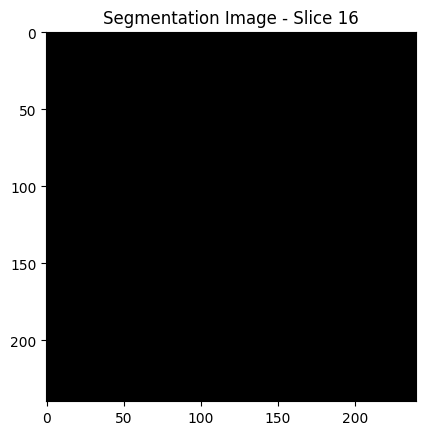

Shape of combined_mri for validation index 2: torch.Size([4, 240, 240, 155])


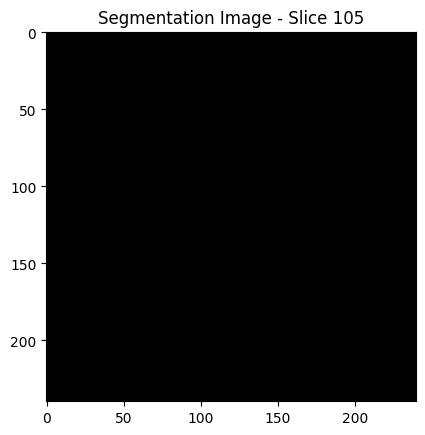

In [22]:
# Actually create the datasets

train_dataset = ImageDataset(data_path_dictionary_train)
val_dataset = ImageDataset(data_path_dictionary_valid)

print("Train Dataset", train_dataset)
print("Val Dataset", val_dataset)

print("Length of train dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))

# Helper function to display a random slice
def display_random_slice(seg_img):
    random_slice = random.randint(0, seg_img.shape[2] - 1)
    plt.imshow(seg_img[:, :, random_slice], cmap='gray')
    plt.title(f'Segmentation Image - Slice {random_slice}')
    plt.show()

# Get a random index
random_idx = random.randint(0, len(train_dataset) - 1)

# Get the data for that index
combined_mri, seg_img = train_dataset[random_idx]

# Print shape of combined_mri
print(f"Shape of combined_mri for index {random_idx}: {combined_mri.shape}")

# Display a random slice of seg_img
display_random_slice(seg_img)

# Repeat for validation dataset
random_idx = random.randint(0, len(val_dataset) - 1)
combined_mri, seg_img = val_dataset[random_idx]
print(f"Shape of combined_mri for validation index {random_idx}: {combined_mri.shape}")
display_random_slice(seg_img)


In [5]:
# Define batch size
batch_size = 16  # remember each item in a batch actually contains 155 subbatches

# Create DataLoader instances for train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print("train_loader", train_loader)
print("val_loader", val_loader)

train_loader <torch.utils.data.dataloader.DataLoader object at 0x7f8f2eef8d30>
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f8f2eef8dc0>


# The Model

In [6]:
from seg_models import UNet, UNetPaper


In [7]:
# Best case? lr = 0.00001, bce, 

# Define the number of classes
num_output_classes = 1 #normally should be 5
num_input_channels = 4

# Custom Models
model = UNet(num_input_channels, num_output_classes)
model = model.to(device)

# Paper Models
# model = UNetPaper(num_input_channels, num_output_classes)
# model = model.to(device)

# Define the loss function
# criterion =nn.CrossEntropyLoss()
criterion = nn.BCELoss()
criterion = criterion.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-5) # 

# Print model summary
print(model)


UNet(
  (encoder_conv1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequ

In [8]:

num_epochs = 10 # Adjust as needed
train_losses = []
val_losses = []

# if you want to load and continue a model
load_model = True

if load_model:
    saved_models_path = os.path.join(final_project_path, 'saved_models')
    ####### Change the name here #########
    saved_model_path = os.path.join(saved_models_path, 'train_unet1_bce_lr1e-5_10e')
    
    # Load JSON from a file
    with open(f'{saved_model_path}/train_losses.json', 'r') as f:
        train_losses = json.load(f)
    # Load JSON from a file
    with open(f'{saved_model_path}/val_losses.json', 'r') as f:
        val_losses = json.load(f)

    # Add the file name
    saved_weights_path = 'last_unet.pth' # could change to best
    saved_weights_path = os.path.join(saved_model_path, saved_weights_path)
    saved_weights = torch.load(saved_weights_path)

    # Load the weights into the model
    model.load_state_dict(saved_weights)
    
    print("Continuining Previous Model")
    

        
print("train_losses", len(train_losses))
print("val_losses", len(val_losses))

Continuining Previous Model
train_losses 10
val_losses 10


In [9]:
# Training loop

# Define variables to track the best model and its validation loss
best_val_loss = float('inf')
best_model_weights = None

for epoch in range(num_epochs):
    start_time = time.time()  # Start timer for epoch
    model.train()
    running_train_loss = 0.0
    for combined_mris, seg_imgs in train_loader:

        
        number_of_slices = combined_mris.size(4)
        print("New Batch, slices:", number_of_slices)
        
        # Create a list of depth indices and shuffle it
        depth_indices = list(range(number_of_slices))
        random.shuffle(depth_indices)
        
        for depth_idx in depth_indices:  # Iterate over depth slices, should always be 155 anyways
            # Get the current depth slice and reshape it
            current_slice = combined_mris[:, :, :, :, depth_idx].to(device)
            # print("current_slice", current_slice.shape, torch.unique(current_slice.reshape(-1)), current_slice)
            
            
            # Multiple Class Option
            # Reshape seg_imgs for the current depth slice, multiple class
#             current_seg = seg_imgs[:, :, :, depth_idx].long()
#             current_seg_one_hot = F.one_hot(current_seg, num_output_classes).permute(0, 3, 1, 2).float().to(device)
#             print("current_seg", current_seg_one_hot.shape, torch.unique(current_seg.reshape(-1)), current_seg_one_hot)
            
            # Binary option
            current_seg = seg_imgs[:, :, :, depth_idx].long()
            current_seg_one_hot = current_seg.unsqueeze(1).float().to(device)
            # print("current_seg", current_seg_one_hot.shape, torch.unique(current_seg.reshape(-1)), current_seg_one_hot)
            
            
            if(len(torch.unique(current_seg.reshape(-1))) == 1):
                continue #dont learn if there is no mask? 

            
            # Predict
            outputs = model(current_slice.float())
            # print("outputs_fixed", outputs.shape, outputs)
            
            # Compute loss for the current depth slice
            loss = criterion(outputs, current_seg_one_hot)
            # print("loss", loss)
            
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            
    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for combined_mris, seg_imgs in val_loader:
            
            number_of_slices = combined_mris.size(4)
            print("Validation Batch, slices:", number_of_slices)

            depth_indices = list(range(number_of_slices))  # List of depth indices
            random.shuffle(depth_indices)  # Shuffle the depth indices
            
            for depth_idx in depth_indices:  # Iterate over depth slices, should always be 155 anyways
                # Get the current depth slice and reshape it
                current_slice = combined_mris[:, :, :, :, depth_idx].to(device)
                
                # Binary option for segmentation
                current_seg = seg_imgs[:, :, :, depth_idx].long()
                current_seg_one_hot = current_seg.unsqueeze(1).float().to(device)
                
                                
                # Predict
                outputs = model(current_slice.float())

                # Compute loss for the current depth slice
                loss = criterion(outputs, current_seg_one_hot)
                running_val_loss += loss.item()
                

       
            
    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    # Update best_score and store best model weights in memory
    if best_val_loss > val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()
    
    
    end_time = time.time()  # End timer for epoch
    epoch_time = end_time - start_time  # Calculate epoch time
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Time: {epoch_time:.2f} seconds")
    # print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Time: {epoch_time:.2f} seconds")


New Batch, slices: 155
New Batch, slices: 155
New Batch, slices: 155
New Batch, slices: 155
New Batch, slices: 155
Validation Batch, slices: 155
Validation Batch, slices: 155
Epoch 1, Train Loss: 0.8705863299437624, Val Loss: 1.1160047037149923, Time: 496.38 seconds
New Batch, slices: 155
New Batch, slices: 155
New Batch, slices: 155
New Batch, slices: 155
New Batch, slices: 155
Validation Batch, slices: 155
Validation Batch, slices: 155
Epoch 2, Train Loss: 0.8474786790713551, Val Loss: 1.4201317656128936, Time: 491.36 seconds
New Batch, slices: 155
New Batch, slices: 155
New Batch, slices: 155
New Batch, slices: 155
New Batch, slices: 155
Validation Batch, slices: 155
Validation Batch, slices: 155
Epoch 3, Train Loss: 0.818396500131712, Val Loss: 1.119284905060141, Time: 486.49 seconds
New Batch, slices: 155
New Batch, slices: 155
New Batch, slices: 155
New Batch, slices: 155
New Batch, slices: 155
Validation Batch, slices: 155
Validation Batch, slices: 155
Epoch 4, Train Loss: 0.787

### Save the Model

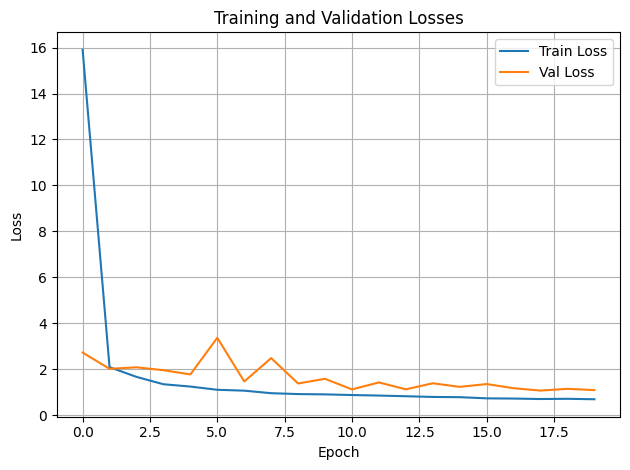

In [10]:
import time

# Create the saved_models folder if it doesn't exist
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Generate a unique train_number based on current timestamp
train_number = time.strftime("%Y%m%d_%H%M%S")
train_folder = f'saved_models/train_{train_number}'

# Create the train_number subfolder inside saved_models
if not os.path.exists(train_folder):
    os.makedirs(train_folder)

# Save the last and best model to the train_number subfolder
torch.save(model.state_dict(), f'{train_folder}/last_unet.pth')
torch.save(best_model_weights, f'{train_folder}/best_unet.pth')


# Save the losses too 

# Save scores_record to a file
with open(f'{train_folder}/train_losses.json', 'w') as f:
    json.dump(train_losses, f)

# Save loss_record to a file
with open(f'{train_folder}/val_losses.json', 'w') as f:
    json.dump(val_losses, f)

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)

# Save the plots to the train_number subfolder
plt.savefig(f'{train_folder}/metrics_plot.png')

plt.tight_layout()
plt.show()

